In [2]:
import os, glob, time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


IMG_DIR: C:\Users\minho.lee\Desktop\img_align_celeba_25k\img_align_celeba_25k
ATTR_TXT: C:\Users\minho.lee\Desktop\img_align_celeba_25k\list_attr_celeba.txt
IMG_DIR exists: True
ATTR_TXT exists: True
Total images in attr file: 202599
Num attributes: 40
Skipped (not found on disk): 5
Picked: ['003474.jpg', '022750.jpg', '024482.jpg']


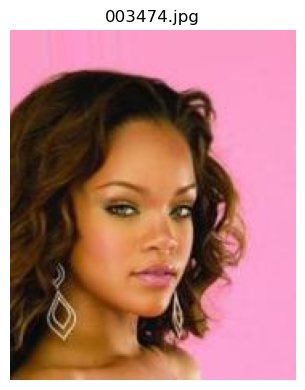


Attributes for 003474.jpg (value == 1):
['Attractive', 'Brown_Hair', 'Heavy_Makeup', 'No_Beard', 'Oval_Face', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Lipstick', 'Young']
------------------------------------------------------------


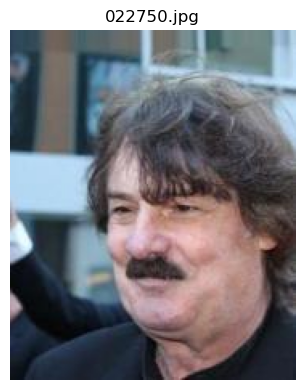


Attributes for 022750.jpg (value == 1):
['Bags_Under_Eyes', 'Big_Nose', 'Chubby', 'Double_Chin', 'High_Cheekbones', 'Male', 'Mustache', 'Wavy_Hair']
------------------------------------------------------------


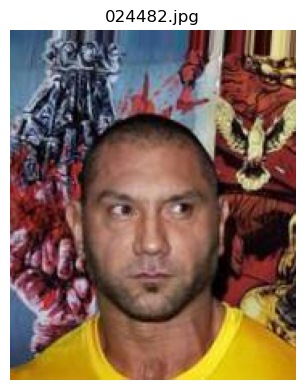


Attributes for 024482.jpg (value == 1):
['5_o_Clock_Shadow', 'Big_Nose', 'Male', 'Sideburns', 'Young']
------------------------------------------------------------


In [ ]:
%matplotlib inline

import os
import random
from PIL import Image
import matplotlib.pyplot as plt

ROOT = r"C:\Users\minho.lee\Desktop\img_align_celeba_25k"
IMG_DIR = os.path.join(ROOT, "img_align_celeba_25k")
ATTR_TXT = os.path.join(ROOT, "list_attr_celeba.txt")

print("IMG_DIR:", IMG_DIR)
print("ATTR_TXT:", ATTR_TXT)
print("IMG_DIR exists:", os.path.exists(IMG_DIR))
print("ATTR_TXT exists:", os.path.exists(ATTR_TXT))

# Read attribute file
with open(ATTR_TXT, "r") as f:
    lines = f.read().splitlines()

num_images = int(lines[0])
attr_names = lines[1].split()

attr_table = {}
for row in lines[2:]:
    parts = row.split()
    fname = parts[0]
    values = list(map(int, parts[1:]))
    attr_table[fname] = dict(zip(attr_names, values))

print("Total images in attr file:", num_images)
print("Num attributes:", len(attr_names))

# Pick 3 filenames,
all_filenames = list(attr_table.keys())
random.shuffle(all_filenames)

picked = []
skipped = 0

for fname in all_filenames:
    img_path = os.path.join(IMG_DIR, fname)
    if os.path.exists(img_path):
        picked.append(fname)
    else:
        skipped += 1
    if len(picked) == 3:
        break

print("Skipped (not found on disk):", skipped)
print("Picked:", picked)

# Display
for fname in picked:
    img_path = os.path.join(IMG_DIR, fname)

    img = Image.open(img_path).convert("RGB")

    positive_attributes = [a for a, v in attr_table[fname].items() if v == 1]

    # Show image 
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(fname)
    plt.tight_layout()
    plt.show()

    print(f"\nAttributes for {fname} (value == 1):")
    print(positive_attributes)
    print("-" * 60)


### Generator (G)

Input

- Noise vector z ∈ R^{Z_DIM}

- Attribute label y ∈ {0,1}

#### Conditioning

- Concatenate [z, y] → fully connected projection

### Loss Functions
Discriminator Loss

- Binary cross-entropy with logits

- Real images → target 1

- Fake images → target 0

#### Generator Loss

- Binary cross-entropy

- Tries to fool discriminator: D(G(z,y)) → 1


### Training Loop

#### Train Discriminator

Real images + real labels

Fake images (detached) + fake labels

#### Train Generator

Generate images conditioned on random labels

Backprop through discriminator (D frozen)

In [ ]:
# =========================
# PATHS (Windows)
# =========================
ROOT = r"C:\Users\minho.lee\Desktop\img_align_celeba_25k"
IMG_DIR = os.path.join(ROOT, "img_align_celeba_25k")
ATTR_TXT = os.path.join(ROOT, "list_attr_celeba.txt")

assert os.path.exists(IMG_DIR)
assert os.path.exists(ATTR_TXT)

# =========================
# CONFIG
# =========================
IMG_SIZE   = 64
BATCH_SIZE = 128
Z_DIM      = 128
EPOCHS     = 30
LR         = 2e-4
BETA1      = 0.5

COND_ATTR = "Smiling"   # Condition on "Smiling" attribute


In [8]:
def load_celeba_attrs(attr_path):
    with open(attr_path, "r") as f:
        lines = f.read().splitlines()

    n_imgs = int(lines[0])
    headers = lines[1].split()

    table = {}
    for row in lines[2:]:
        parts = row.split()
        fname = parts[0]
        vals = list(map(int, parts[1:]))  # -1 / 1
        table[fname] = dict(zip(headers, vals))

    return headers, table


In [ ]:
class CelebA25kDataset(Dataset):
    def __init__(self, img_dir, attr_txt, cond_attr, transform=None, max_items=None):
        self.img_dir = img_dir
        self.transform = transform
        self.cond_attr = cond_attr

        headers, table = load_celeba_attrs(attr_txt)
        assert cond_attr in headers, f"{cond_attr} not in attributes"

        self.samples = []
        for fname in sorted(table.keys()):
            img_path = os.path.join(img_dir, fname)
            if not os.path.exists(img_path):
                continue
            y = 1.0 if table[fname][cond_attr] == 1 else 0.0
            self.samples.append((img_path, y))

        # 
        if max_items is not None:
            self.samples = self.samples[:max_items]

        ys = [y for _, y in self.samples]
        print(f"Dataset size: {len(self.samples)} | {cond_attr}=1 ratio: {np.mean(ys):.3f}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, y = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        y = torch.tensor([y], dtype=torch.float32)
        return img, y


In [ ]:
DEMO_N = 2000   # ***only for demo purposes

dataset = CelebA25kDataset(
    IMG_DIR,
    ATTR_TXT,
    cond_attr=COND_ATTR,
    transform=transform,
    max_items=DEMO_N      # 
)


Dataset size: 2000 | Smiling=1 ratio: 0.480


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(Z_DIM + 1, 4*4*512, bias=False),
            nn.BatchNorm1d(4*4*512),
            nn.ReLU(True),
        )

        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z, y):
        x = torch.cat([z, y], dim=1) #### **Here we append the label to the z**
        x = self.fc(x).view(x.size(0), 512, 4, 4)
        return self.net(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.head = nn.Conv2d(512, 1, 4, 1, 0)

    def forward(self, img, y):
        b, _, h, w = img.shape
        ymap = y.view(b, 1, 1, 1).expand(b, 1, h, w) #### **Here we extend the label to a feature map (4th dim)**
        x = torch.cat([img, ymap], dim=1)
        x = self.net(x)
        return self.head(x).view(b, 1)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

G.apply(weights_init)
D.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()
g_opt = torch.optim.Adam(G.parameters(), lr=LR, betas=(BETA1, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(BETA1, 0.999))


In [23]:
def sample_noise(bs):
    return torch.randn(bs, Z_DIM, device=device)

@torch.no_grad()
def show_samples(label, title):
    z = sample_noise(16)
    y = torch.full((16,1), float(label), device=device)
    fake = G(z, y)
    imgs = (fake + 1) / 2
    imgs = imgs.cpu().permute(0,2,3,1).numpy()

    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


NameError: name 'torch' is not defined

[Epoch 001] D 0.8683 | G 3.6702 | 3.6s


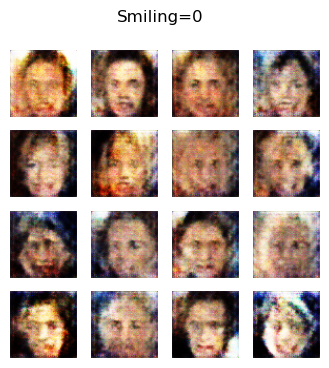

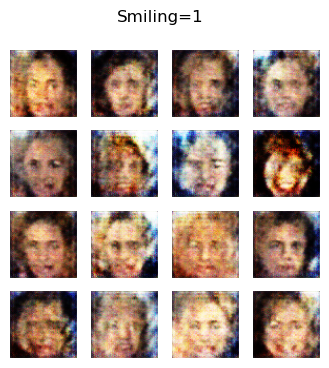

[Epoch 002] D 0.8597 | G 3.6637 | 3.7s
[Epoch 003] D 0.8049 | G 3.7913 | 3.8s
[Epoch 004] D 0.8667 | G 3.7731 | 3.7s
[Epoch 005] D 0.7205 | G 4.1030 | 3.7s


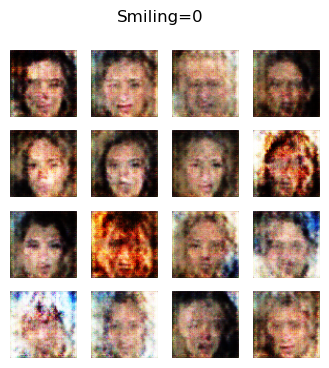

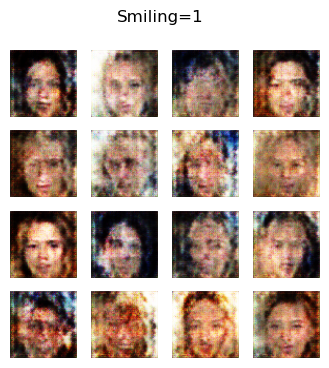

[Epoch 006] D 0.7671 | G 4.0260 | 3.7s
[Epoch 007] D 0.7415 | G 3.4815 | 3.9s
[Epoch 008] D 0.8471 | G 3.8025 | 3.7s
[Epoch 009] D 0.9134 | G 4.1281 | 3.8s
[Epoch 010] D 0.6373 | G 3.7712 | 3.9s


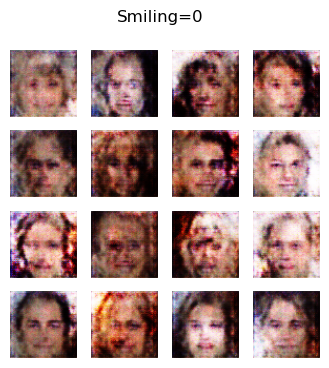

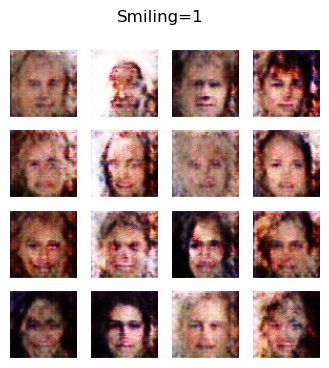

[Epoch 011] D 0.6895 | G 3.7796 | 3.8s
[Epoch 012] D 0.7386 | G 3.6979 | 3.7s
[Epoch 013] D 0.5938 | G 3.6477 | 3.8s
[Epoch 014] D 0.6492 | G 3.8359 | 3.7s
[Epoch 015] D 0.7816 | G 3.8076 | 3.7s


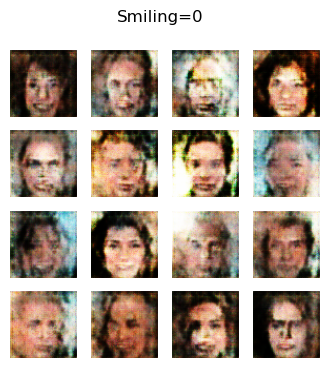

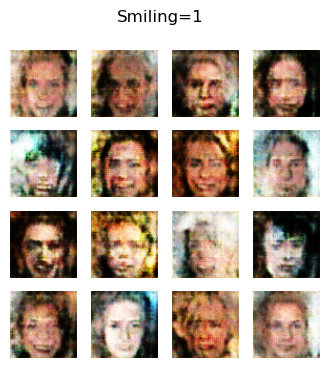

[Epoch 016] D 0.6927 | G 3.6955 | 3.7s
[Epoch 017] D 0.6466 | G 3.5750 | 3.7s
[Epoch 018] D 0.7504 | G 3.5444 | 3.7s
[Epoch 019] D 0.6610 | G 3.6065 | 3.9s
[Epoch 020] D 0.5536 | G 3.3016 | 3.8s


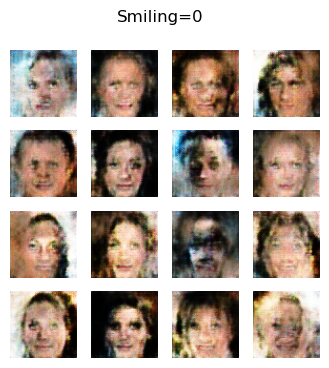

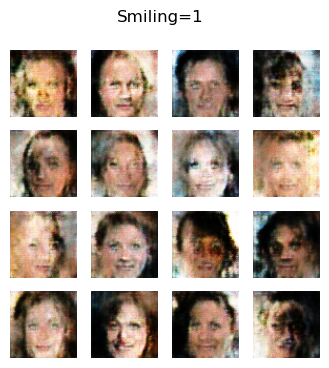

[Epoch 021] D 0.5071 | G 3.1605 | 3.7s
[Epoch 022] D 0.7821 | G 3.6406 | 3.7s
[Epoch 023] D 0.7579 | G 3.9215 | 3.7s
[Epoch 024] D 0.6317 | G 3.6137 | 3.7s
[Epoch 025] D 0.4934 | G 3.4700 | 3.8s


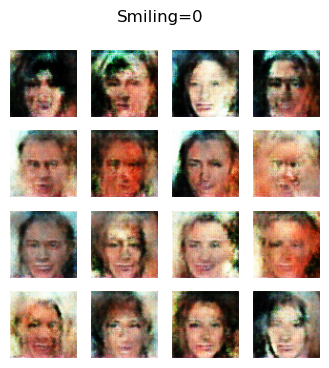

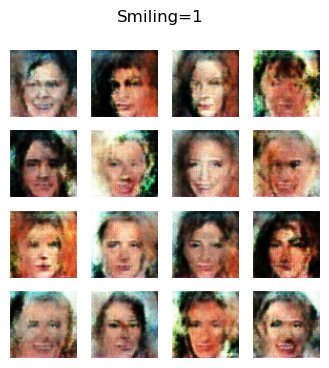

[Epoch 026] D 0.6830 | G 3.9560 | 3.7s
[Epoch 027] D 0.7050 | G 3.7201 | 3.7s
[Epoch 028] D 0.5972 | G 3.4829 | 3.8s
[Epoch 029] D 0.5854 | G 3.4660 | 3.8s
[Epoch 030] D 0.6433 | G 3.6755 | 3.7s


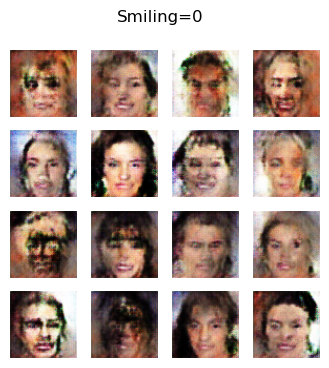

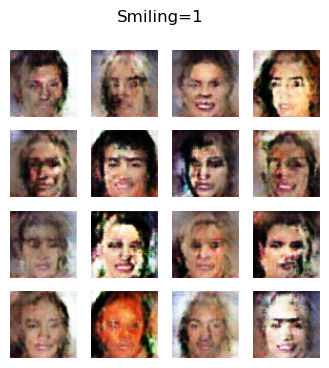

In [25]:
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,   #
    drop_last=True
)

for epoch in range(1, EPOCHS+1):
    d_losses, g_losses = [], []
    t0 = time.time()

    for real_imgs, y_real in loader:
        real_imgs = real_imgs.to(device)
        y_real = y_real.to(device)
        bs = real_imgs.size(0)

        # ---- Train D ----
        D.zero_grad(set_to_none=True)

        real_logits = D(real_imgs, y_real)
        d_real = criterion(real_logits, torch.ones(bs, 1, device=device))

        z = sample_noise(bs)
        y_fake = (torch.rand(bs, 1, device=device) < 0.5).float()
        fake_imgs = G(z, y_fake).detach()
        fake_logits = D(fake_imgs, y_fake)
        d_fake = criterion(fake_logits, torch.zeros(bs, 1, device=device))

        d_loss = d_real + d_fake
        d_loss.backward()
        d_opt.step()

        # ---- Train G ----
        G.zero_grad(set_to_none=True)

        z = sample_noise(bs)
        y = (torch.rand(bs, 1, device=device) < 0.5).float()
        gen_imgs = G(z, y)
        g_loss = criterion(D(gen_imgs, y), torch.ones(bs, 1, device=device))

        g_loss.backward()
        g_opt.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    print(f"[Epoch {epoch:03d}] D {np.mean(d_losses):.4f} | G {np.mean(g_losses):.4f} | {time.time()-t0:.1f}s")

    if epoch == 1 or epoch % 5 == 0:
        show_samples(0.0, f"{COND_ATTR}=0")
        show_samples(1.0, f"{COND_ATTR}=1")


## (optional 1 extra point) Task. Multi-Attribute Conditional Generation

### Objective
Extend the current **binary conditional GAN** to support **multiple attributes (≥ 5)**  
and demonstrate **explicit control of the Generator** using a **one-hot / multi-hot condition vector**.

Example condition vector: y = [0, 1, 1, 1, 0, 0, 0]

1. **Select Multiple Attributes**
   - Choose **at least 5 attributes** from CelebA  
     (e.g., `Smiling`, `Male`, `Young`, `Eyeglasses`, `Blond_Hair`, …)
     ```
     [Smiling, Male, Young, Eyeglasses, Blond_Hair]
     → y = [1, 0, 1, 0, 1]
     ```

2. **Controllability Demonstration**
   - Fix noise `z`
   - Vary only the condition vector `y`
   - Show that **semantic attributes change while identity remains stable**

There is no restriction on the conditional GAN structure, as long as the conditioning mechanism is clearly defined and justified.


1. Add the inference code below, it demonstrate showing more than 10 images and their input conditioning
2. Explain the conditioning mechanism you used and why you chose it.
If the generated results are unsatisfactory, discuss potential causes such as model design, training instability, or insufficient conditioning.

## Multi-Attribute cGAN Implementation (Google Colab Ready)

This implementation:
1. Downloads CelebA from torchvision's public distribution
2. Uses 5+ attributes: `Smiling`, `Male`, `Young`, `Eyeglasses`, `Blond_Hair`, `Wearing_Hat`, `Heavy_Makeup`
3. Conditions both Generator and Discriminator on a multi-hot vector

In [ ]:
# =============================================================================
# CELL 1: Setup & Imports (Run this first on Google Colab)
# =============================================================================
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

# Check if running on Colab
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab!")
except:
    IN_COLAB = False
    print("Not running on Colab")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# =============================================================================
# CELL 2: Download CelebA via Kaggle (More Reliable than GDrive)
# =============================================================================
# Google Drive often has quota issues. Using Kaggle is more reliable.

# STEP 1: Set up Kaggle credentials
# You need a Kaggle account. Get your API key from https://www.kaggle.com/settings
# Click "Create New Token" to download kaggle.json

import os

if IN_COLAB:
    DATA_ROOT = "/content/celeba_data"
    
    # Install kaggle if needed
    import subprocess
    subprocess.run(["pip", "install", "-q", "kaggle"], check=True)
    
    # Create kaggle directory
    os.makedirs("/root/.kaggle", exist_ok=True)
    
    # Upload your kaggle.json file
    print("=" * 60)
    print("STEP 1: Upload your kaggle.json file")
    print("Get it from: https://www.kaggle.com/settings -> Create New Token")
    print("=" * 60)
    
    from google.colab import files
    uploaded = files.upload()  # This will prompt you to upload kaggle.json
    
    # Move to correct location
    if 'kaggle.json' in uploaded:
        with open('/root/.kaggle/kaggle.json', 'wb') as f:
            f.write(uploaded['kaggle.json'])
        os.chmod('/root/.kaggle/kaggle.json', 0o600)
        print("✓ Kaggle credentials set up successfully!")
    else:
        raise Exception("Please upload kaggle.json file")
else:
    DATA_ROOT = "./celeba_data"

os.makedirs(DATA_ROOT, exist_ok=True)
print(f"Data root: {DATA_ROOT}")

In [ ]:
# =============================================================================
# CELL 2b: Download and Extract CelebA from Kaggle
# =============================================================================

import subprocess
import zipfile

# Check if already downloaded - try multiple possible locations
possible_img_dirs = [
    os.path.join(DATA_ROOT, "img_align_celeba", "img_align_celeba"),
    os.path.join(DATA_ROOT, "img_align_celeba"),
    os.path.join(DATA_ROOT, "celeba", "img_align_celeba"),
]

possible_attr_files = [
    os.path.join(DATA_ROOT, "list_attr_celeba.csv"),
    os.path.join(DATA_ROOT, "celeba", "list_attr_celeba.csv"),
]

IMG_DIR = None
ATTR_FILE = None

# Find existing paths
for path in possible_img_dirs:
    if os.path.exists(path) and os.path.isdir(path):
        files = os.listdir(path)
        if len(files) > 100 and any(f.endswith('.jpg') for f in files[:10]):
            IMG_DIR = path
            break

for path in possible_attr_files:
    if os.path.exists(path):
        ATTR_FILE = path
        break

# Download if not found
if IMG_DIR is None or ATTR_FILE is None:
    print("Downloading CelebA from Kaggle...")
    print("This will take a few minutes (~1.4GB)...")
    
    # Download the dataset
    subprocess.run([
        "kaggle", "datasets", "download", "-d", "jessicali9530/celeba-dataset",
        "-p", DATA_ROOT
    ], check=True)
    
    # Extract
    zip_path = os.path.join(DATA_ROOT, "celeba-dataset.zip")
    print(f"\nExtracting {zip_path}...")
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_ROOT)
    
    # Clean up zip
    if os.path.exists(zip_path):
        os.remove(zip_path)
    print("✓ Extraction complete!")
    
    # Find paths again after extraction
    for path in possible_img_dirs:
        if os.path.exists(path) and os.path.isdir(path):
            files = os.listdir(path)
            if len(files) > 100:
                IMG_DIR = path
                break
    
    for path in possible_attr_files:
        if os.path.exists(path):
            ATTR_FILE = path
            break

# Show what we found
print(f"\n{'='*60}")
print("Dataset paths found:")
print(f"  IMG_DIR: {IMG_DIR}")
print(f"  ATTR_FILE: {ATTR_FILE}")

if IMG_DIR:
    sample_files = os.listdir(IMG_DIR)[:5]
    print(f"  Sample files: {sample_files}")
    print(f"  Total images: {len(os.listdir(IMG_DIR))}")
else:
    print("\n⚠️ Could not find image directory!")
    print("Let's check what was extracted:")
    for root, dirs, files in os.walk(DATA_ROOT):
        level = root.replace(DATA_ROOT, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        if level < 2:  # Only show 2 levels deep
            for f in files[:3]:
                print(f'{indent}  {f}')
            if len(files) > 3:
                print(f'{indent}  ... and {len(files)-3} more files')

In [ ]:
# =============================================================================
# CELL 3: Load Attributes and Configuration
# =============================================================================
import pandas as pd

# Load attribute CSV from Kaggle dataset
attr_df = pd.read_csv(ATTR_FILE)
print(f"Loaded attributes for {len(attr_df)} images")
print(f"Columns: {list(attr_df.columns[:5])}... ({len(attr_df.columns)} total)")

# Get attribute names (all columns except 'image_id')
ALL_ATTR_NAMES = [col for col in attr_df.columns if col != 'image_id']

# Select 7 attributes for conditioning (you can modify this list)
SELECTED_ATTRS = [
    'Smiling',        # 0 - Facial expression
    'Male',           # 1 - Gender
    'Young',          # 2 - Age
    'Eyeglasses',     # 3 - Accessory
    'Blond_Hair',     # 4 - Hair color
    'Wearing_Hat',    # 5 - Accessory
    'Heavy_Makeup',   # 6 - Makeup
]

NUM_ATTRS = len(SELECTED_ATTRS)

# Verify all selected attributes exist
for attr in SELECTED_ATTRS:
    assert attr in ALL_ATTR_NAMES, f"Attribute '{attr}' not found in dataset"

print(f"\nSelected {NUM_ATTRS} attributes:")
for i, name in enumerate(SELECTED_ATTRS):
    # Convert -1/1 to 0/1 and calculate frequency
    freq = (attr_df[name] == 1).mean()
    print(f"  [{i}] {name}: {freq:.1%} positive")

# Hyperparameters
IMG_SIZE   = 64
BATCH_SIZE = 64  # Reduced for Colab GPU memory
Z_DIM      = 128
EPOCHS     = 25
LR         = 2e-4
BETA1      = 0.5

# For demo/testing, limit dataset size (set to None for full dataset)
MAX_SAMPLES = 20000  # Use 20k samples for faster training; set None for full

In [ ]:
# =============================================================================
# CELL 4: Multi-Attribute Dataset (Kaggle CSV Format)
# =============================================================================

class MultiAttrCelebAKaggle(Dataset):
    """
    Custom Dataset for CelebA from Kaggle.
    Reads images from folder and attributes from CSV.
    Returns images and multi-hot attribute vectors.
    """
    def __init__(self, img_dir, attr_df, selected_attrs, transform=None, max_samples=None):
        self.img_dir = img_dir
        self.transform = transform
        self.selected_attrs = selected_attrs
        
        # Filter to only existing images
        self.samples = []
        checked = 0
        not_found = 0
        
        for idx, row in attr_df.iterrows():
            img_name = row['image_id']
            img_path = os.path.join(img_dir, img_name)
            
            checked += 1
            
            if os.path.exists(img_path):
                # Extract selected attributes, convert -1/1 to 0/1
                attrs = []
                for attr in selected_attrs:
                    val = 1.0 if row[attr] == 1 else 0.0
                    attrs.append(val)
                self.samples.append((img_path, attrs))
            else:
                not_found += 1
                if not_found <= 3:  # Show first few missing
                    print(f"  Not found: {img_path}")
            
            # Limit samples if specified
            if max_samples is not None and len(self.samples) >= max_samples:
                break
            
            # Progress update
            if checked % 50000 == 0:
                print(f"  Checked {checked} entries, found {len(self.samples)} images...")
        
        print(f"\nDataset size: {len(self.samples)}")
        print(f"Checked {checked} entries, {not_found} images not found on disk")
        
        # Compute attribute statistics (only if we have samples)
        if len(self.samples) > 0:
            all_attrs = np.array([s[1] for s in self.samples])
            attr_means = all_attrs.mean(axis=0)
            
            print("Attribute frequencies:")
            for i, (name, mean) in enumerate(zip(selected_attrs, attr_means)):
                print(f"  {name}: {mean:.1%}")
        else:
            print("\n⚠️ WARNING: No images found!")
            print(f"  IMG_DIR: {img_dir}")
            print(f"  Expected images like: {attr_df['image_id'].iloc[0] if len(attr_df) > 0 else 'N/A'}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, attrs = self.samples[idx]
        
        # Load image
        img = Image.open(img_path).convert("RGB")
        
        # Apply transform
        if self.transform:
            img = self.transform(img)
        
        # Convert attributes to tensor
        y = torch.tensor(attrs, dtype=torch.float32)
        
        return img, y

# Define transforms
transform = transforms.Compose([
    transforms.CenterCrop(178),  # Crop to face region
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Scale to [-1, 1]
])

# Create dataset
print("Loading dataset...")
print(f"Looking for images in: {IMG_DIR}")

dataset = MultiAttrCelebAKaggle(
    img_dir=IMG_DIR,
    attr_df=attr_df,
    selected_attrs=SELECTED_ATTRS,
    transform=transform,
    max_samples=MAX_SAMPLES
)

# Only create DataLoader if we have data
if len(dataset) > 0:
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2 if IN_COLAB else 0,
        pin_memory=True,
        drop_last=True
    )
    print(f"\n✓ DataLoader created with {len(loader)} batches per epoch")
else:
    print("\n❌ Cannot create DataLoader - no images found!")
    print("Please re-run Cell 2b and check the extracted folder structure.")

In [ ]:
# =============================================================================
# CELL 5: Multi-Attribute Generator
# =============================================================================

class MultiAttrGenerator(nn.Module):
    """
    Generator conditioned on multiple attributes.
    
    Conditioning Mechanism:
    - Concatenates noise z (Z_DIM) with multi-hot attribute vector y (NUM_ATTRS)
    - Projects combined vector through FC layer to spatial features
    - Uses transposed convolutions to upsample to final image
    
    Architecture: FC -> 4x4x512 -> 8x8x256 -> 16x16x128 -> 32x32x64 -> 64x64x3
    """
    def __init__(self, z_dim=Z_DIM, num_attrs=NUM_ATTRS):
        super().__init__()
        self.z_dim = z_dim
        self.num_attrs = num_attrs
        
        # Project [z, y] to spatial features
        # Input: z_dim + num_attrs, Output: 4*4*512
        self.fc = nn.Sequential(
            nn.Linear(z_dim + num_attrs, 4 * 4 * 512, bias=False),
            nn.BatchNorm1d(4 * 4 * 512),
            nn.ReLU(True),
        )
        
        # Transposed conv layers for upsampling
        self.net = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            # Final conv to RGB
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Tanh()
        )
    
    def forward(self, z, y):
        """
        Args:
            z: Noise vector, shape (batch, z_dim)
            y: Multi-hot attribute vector, shape (batch, num_attrs)
        Returns:
            Generated image, shape (batch, 3, 64, 64)
        """
        # Concatenate noise and attributes
        x = torch.cat([z, y], dim=1)  # (batch, z_dim + num_attrs)
        
        # Project to spatial features
        x = self.fc(x)  # (batch, 4*4*512)
        x = x.view(-1, 512, 4, 4)  # (batch, 512, 4, 4)
        
        # Generate image
        return self.net(x)

print(f"Generator input: z({Z_DIM}) + y({NUM_ATTRS}) = {Z_DIM + NUM_ATTRS} dimensions")

In [ ]:
# =============================================================================
# CELL 6: Multi-Attribute Discriminator
# =============================================================================

class MultiAttrDiscriminator(nn.Module):
    """
    Discriminator conditioned on multiple attributes.
    
    Conditioning Mechanism:
    - Expands multi-hot vector y to spatial feature maps (same H, W as image)
    - Concatenates with image along channel dimension: 3 + NUM_ATTRS channels
    - Processes through conv layers to predict real/fake
    
    This approach (projection-style conditioning) allows the discriminator
    to evaluate both image quality AND attribute consistency simultaneously.
    
    Architecture: (3+NUM_ATTRS) -> 64 -> 128 -> 256 -> 512 -> 1
    """
    def __init__(self, num_attrs=NUM_ATTRS):
        super().__init__()
        self.num_attrs = num_attrs
        
        # Input: image (3 channels) + attribute maps (num_attrs channels)
        self.net = nn.Sequential(
            # 64x64 -> 32x32
            nn.Conv2d(3 + num_attrs, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 32x32 -> 16x16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 16x16 -> 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 8x8 -> 4x4
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Final classification: 4x4 -> 1x1
        self.head = nn.Conv2d(512, 1, 4, 1, 0)
    
    def forward(self, img, y):
        """
        Args:
            img: Image tensor, shape (batch, 3, 64, 64)
            y: Multi-hot attribute vector, shape (batch, num_attrs)
        Returns:
            Logits for real/fake, shape (batch, 1)
        """
        b, c, h, w = img.shape
        
        # Expand y to spatial feature maps
        # (batch, num_attrs) -> (batch, num_attrs, 64, 64)
        y_map = y.view(b, self.num_attrs, 1, 1).expand(b, self.num_attrs, h, w)
        
        # Concatenate image with attribute maps
        x = torch.cat([img, y_map], dim=1)  # (batch, 3 + num_attrs, 64, 64)
        
        # Forward through network
        x = self.net(x)
        return self.head(x).view(b, 1)

print(f"Discriminator input: image(3) + y_map({NUM_ATTRS}) = {3 + NUM_ATTRS} channels")

In [ ]:
# =============================================================================
# CELL 7: Initialize Models and Optimizers
# =============================================================================

# Create models
G = MultiAttrGenerator(z_dim=Z_DIM, num_attrs=NUM_ATTRS).to(device)
D = MultiAttrDiscriminator(num_attrs=NUM_ATTRS).to(device)

# Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
g_opt = torch.optim.Adam(G.parameters(), lr=LR, betas=(BETA1, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(BETA1, 0.999))

# Print model summaries
print("Generator:")
print(f"  Total parameters: {sum(p.numel() for p in G.parameters()):,}")
print("\nDiscriminator:")
print(f"  Total parameters: {sum(p.numel() for p in D.parameters()):,}")

In [ ]:
# =============================================================================
# CELL 8: Utility Functions for Sampling and Visualization
# =============================================================================

def sample_noise(batch_size):
    """Generate random noise vectors."""
    return torch.randn(batch_size, Z_DIM, device=device)

def sample_random_attrs(batch_size):
    """Generate random multi-hot attribute vectors."""
    return (torch.rand(batch_size, NUM_ATTRS, device=device) > 0.5).float()

def attrs_to_string(attrs):
    """Convert attribute tensor to human-readable string."""
    if attrs.dim() == 1:
        attrs = attrs.unsqueeze(0)
    
    result = []
    for row in attrs:
        active = [SELECTED_ATTRS[i][:3] for i, v in enumerate(row) if v > 0.5]
        result.append(", ".join(active) if active else "None")
    return result

@torch.no_grad()
def show_samples_grid(attributes_list, title="Generated Samples", fixed_z=None):
    """
    Generate and display samples for given attribute combinations.
    
    Args:
        attributes_list: List of attribute tensors or single tensor (n_samples, num_attrs)
        title: Plot title
        fixed_z: Optional fixed noise vector for all samples
    """
    if isinstance(attributes_list, torch.Tensor):
        attrs = attributes_list.to(device)
    else:
        attrs = torch.stack(attributes_list).to(device)
    
    n = len(attrs)
    
    if fixed_z is not None:
        z = fixed_z.expand(n, -1)
    else:
        z = sample_noise(n)
    
    G.eval()
    fake = G(z, attrs)
    G.train()
    
    # Denormalize
    imgs = (fake + 1) / 2
    imgs = imgs.cpu().permute(0, 2, 3, 1).numpy()
    
    # Calculate grid size
    cols = min(4, n)
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes[np.newaxis, :]
    elif cols == 1:
        axes = axes[:, np.newaxis]
    
    attr_strings = attrs_to_string(attrs)
    
    for i in range(rows * cols):
        r, c = i // cols, i % cols
        if i < n:
            axes[r, c].imshow(imgs[i])
            axes[r, c].set_title(attr_strings[i], fontsize=8)
        axes[r, c].axis("off")
    
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

print("Utility functions defined!")

In [ ]:
# =============================================================================
# CELL 9: Training Loop for Multi-Attribute cGAN
# =============================================================================

# Training history
history = {'d_loss': [], 'g_loss': [], 'd_real': [], 'd_fake': []}

print(f"Starting training for {EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}, Batches per epoch: {len(loader)}")
print("-" * 60)

for epoch in range(1, EPOCHS + 1):
    d_losses, g_losses = [], []
    d_real_accs, d_fake_accs = [], []
    t0 = time.time()
    
    for real_imgs, y_real in loader:
        real_imgs = real_imgs.to(device)
        y_real = y_real.to(device)
        bs = real_imgs.size(0)
        
        # Labels
        real_labels = torch.ones(bs, 1, device=device)
        fake_labels = torch.zeros(bs, 1, device=device)
        
        # ==================== Train Discriminator ====================
        D.zero_grad(set_to_none=True)
        
        # Real images with real attributes
        real_logits = D(real_imgs, y_real)
        d_loss_real = criterion(real_logits, real_labels)
        
        # Fake images with random attributes
        z = sample_noise(bs)
        y_fake = sample_random_attrs(bs)
        fake_imgs = G(z, y_fake).detach()
        fake_logits = D(fake_imgs, y_fake)
        d_loss_fake = criterion(fake_logits, fake_labels)
        
        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_opt.step()
        
        # ==================== Train Generator ====================
        G.zero_grad(set_to_none=True)
        
        # Generate new fakes
        z = sample_noise(bs)
        y_gen = sample_random_attrs(bs)
        gen_imgs = G(z, y_gen)
        gen_logits = D(gen_imgs, y_gen)
        
        # Generator tries to fool discriminator
        g_loss = criterion(gen_logits, real_labels)
        g_loss.backward()
        g_opt.step()
        
        # Track losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        d_real_accs.append((real_logits > 0).float().mean().item())
        d_fake_accs.append((fake_logits < 0).float().mean().item())
    
    # Epoch statistics
    avg_d = np.mean(d_losses)
    avg_g = np.mean(g_losses)
    avg_d_real = np.mean(d_real_accs)
    avg_d_fake = np.mean(d_fake_accs)
    
    history['d_loss'].append(avg_d)
    history['g_loss'].append(avg_g)
    history['d_real'].append(avg_d_real)
    history['d_fake'].append(avg_d_fake)
    
    print(f"[Epoch {epoch:02d}/{EPOCHS}] D: {avg_d:.4f} | G: {avg_g:.4f} | "
          f"D(real): {avg_d_real:.2%} | D(fake): {avg_d_fake:.2%} | {time.time()-t0:.1f}s")
    
    # Show samples every 5 epochs
    if epoch == 1 or epoch % 5 == 0:
        # Show random samples
        random_attrs = sample_random_attrs(8)
        show_samples_grid(random_attrs, f"Epoch {epoch} - Random Attributes")

print("\nTraining complete!")

In [ ]:
# =============================================================================
# CELL 10: Plot Training History
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(history['d_loss'], label='Discriminator', color='blue')
axes[0].plot(history['g_loss'], label='Generator', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Losses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['d_real'], label='D(real) accuracy', color='green')
axes[1].plot(history['d_fake'], label='D(fake) accuracy', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Discriminator Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Controllability Demonstration

The following cells demonstrate that the generator has learned to respond to the conditioning vector.

**Key Test:** Fix the noise vector `z` and vary only the attributes `y` - if the model is working correctly, the identity/structure should remain stable while semantic attributes change.

In [ ]:
# =============================================================================
# CELL 11: Controllability Demo - Fixed z, Varying Attributes
# =============================================================================

@torch.no_grad()
def demonstrate_controllability(num_identities=3):
    """
    Demonstrate that varying attributes while keeping z fixed changes semantics
    while preserving identity structure.
    """
    G.eval()
    
    # Define specific attribute combinations to test
    # Format: [Smiling, Male, Young, Eyeglasses, Blond_Hair, Wearing_Hat, Heavy_Makeup]
    test_conditions = [
        ("Base (all off)",           [0, 0, 0, 0, 0, 0, 0]),
        ("Smiling",                  [1, 0, 0, 0, 0, 0, 0]),
        ("Male",                     [0, 1, 0, 0, 0, 0, 0]),
        ("Young + Smiling",          [1, 0, 1, 0, 0, 0, 0]),
        ("Eyeglasses",               [0, 0, 0, 1, 0, 0, 0]),
        ("Blond Hair",               [0, 0, 0, 0, 1, 0, 0]),
        ("Heavy Makeup",             [0, 0, 0, 0, 0, 0, 1]),
        ("Male + Eyeglasses",        [0, 1, 0, 1, 0, 0, 0]),
        ("Female + Blond + Makeup",  [1, 0, 1, 0, 1, 0, 1]),
        ("All attributes ON",        [1, 1, 1, 1, 1, 1, 1]),
    ]
    
    n_conditions = len(test_conditions)
    
    fig, axes = plt.subplots(num_identities, n_conditions, figsize=(2*n_conditions, 2.5*num_identities))
    
    for row in range(num_identities):
        # Fix z for this identity
        z_fixed = sample_noise(1)
        
        for col, (label, attrs) in enumerate(test_conditions):
            y = torch.tensor([attrs], dtype=torch.float32, device=device)
            fake = G(z_fixed, y)
            
            # Denormalize
            img = (fake[0] + 1) / 2
            img = img.cpu().permute(1, 2, 0).numpy()
            
            axes[row, col].imshow(img)
            axes[row, col].axis("off")
            
            if row == 0:
                axes[row, col].set_title(label, fontsize=7, rotation=15, ha='left')
    
    # Add row labels
    for row in range(num_identities):
        axes[row, 0].set_ylabel(f"z_{row+1}", fontsize=10)
    
    plt.suptitle("Fixed Noise (z) with Varying Attributes (y)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    G.train()

# Run demonstration
demonstrate_controllability(num_identities=4)

In [ ]:
# =============================================================================
# CELL 12: Single Attribute Interpolation Demo
# =============================================================================

@torch.no_grad()
def single_attribute_sweep():
    """
    For a fixed identity, toggle each attribute one at a time
    to show individual attribute effects.
    """
    G.eval()
    
    # Fix noise
    z_fixed = sample_noise(1)
    
    # Create grid: rows = attributes, cols = [OFF, ON]
    n_attrs = NUM_ATTRS
    
    fig, axes = plt.subplots(n_attrs, 2, figsize=(4, 2*n_attrs))
    
    for i, attr_name in enumerate(SELECTED_ATTRS):
        for j, val in enumerate([0, 1]):
            # Create attribute vector with only this attribute set
            attrs = torch.zeros(1, NUM_ATTRS, device=device)
            attrs[0, i] = val
            
            fake = G(z_fixed, attrs)
            img = (fake[0] + 1) / 2
            img = img.cpu().permute(1, 2, 0).numpy()
            
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            
            if j == 0:
                axes[i, j].set_ylabel(attr_name, fontsize=10)
            if i == 0:
                axes[i, j].set_title("OFF" if val == 0 else "ON", fontsize=12)
    
    plt.suptitle("Single Attribute Toggle (Same z)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    G.train()

single_attribute_sweep()

In [ ]:
# =============================================================================
# CELL 13: Generate 12+ Diverse Samples with Labels
# =============================================================================

@torch.no_grad()
def generate_diverse_samples(n_samples=12):
    """
    Generate diverse samples showing various attribute combinations.
    """
    G.eval()
    
    # Predefined interesting combinations
    interesting_combos = [
        # [Smiling, Male, Young, Eyeglasses, Blond_Hair, Wearing_Hat, Heavy_Makeup]
        [1, 0, 1, 0, 1, 0, 1],   # Smiling young blonde female with makeup
        [0, 1, 0, 1, 0, 0, 0],   # Older male with glasses
        [1, 1, 1, 0, 0, 0, 0],   # Smiling young male
        [0, 0, 1, 0, 1, 0, 1],   # Young blonde female, not smiling
        [1, 0, 0, 1, 0, 0, 0],   # Smiling older female with glasses
        [0, 1, 1, 1, 1, 0, 0],   # Young male, glasses, blonde
        [1, 0, 1, 0, 0, 1, 1],   # Smiling young female with hat and makeup
        [0, 1, 0, 0, 0, 1, 0],   # Older male with hat
        [1, 1, 1, 1, 0, 0, 0],   # Smiling young male with glasses
        [0, 0, 0, 0, 1, 0, 1],   # Blonde with makeup, not smiling
        [1, 0, 1, 1, 1, 0, 1],   # Smiling young blonde with glasses and makeup
        [0, 1, 1, 0, 1, 1, 0],   # Young blonde male with hat
    ]
    
    # Use predefined combos
    attrs = torch.tensor(interesting_combos[:n_samples], dtype=torch.float32, device=device)
    z = sample_noise(n_samples)
    
    fakes = G(z, attrs)
    imgs = (fakes + 1) / 2
    imgs = imgs.cpu().permute(0, 2, 3, 1).numpy()
    
    # Create figure
    cols = 4
    rows = (n_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()
    
    for i in range(n_samples):
        axes[i].imshow(imgs[i])
        
        # Create label from active attributes
        active = []
        for j, v in enumerate(attrs[i]):
            if v > 0.5:
                active.append(SELECTED_ATTRS[j])
        label = "\n".join(active) if active else "No attrs"
        
        axes[i].set_title(f"Sample {i+1}\n{label}", fontsize=9)
        axes[i].axis("off")
    
    # Hide empty subplots
    for i in range(n_samples, len(axes)):
        axes[i].axis("off")
    
    plt.suptitle("Multi-Attribute Conditional Generation Results", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    G.train()

generate_diverse_samples(12)

## Explanation of Conditioning Mechanism

### Generator Conditioning
The Generator uses **early fusion concatenation**:
- Noise vector `z` (128-dim) and attribute vector `y` (7-dim) are concatenated → 135-dim input
- This combined vector is projected through a fully-connected layer to 4×4×512 spatial features
- The features are then upsampled via transposed convolutions to produce the final 64×64×3 image

**Why this approach:**
- Simple and effective for low-dimensional conditioning
- Attributes influence the generation from the very beginning
- Well-suited for binary/multi-hot attribute vectors

### Discriminator Conditioning
The Discriminator uses **spatial conditioning via feature maps**:
- Each attribute value is broadcast to a full 64×64 spatial map
- These 7 attribute maps are concatenated with the 3 RGB channels → 10 input channels
- The discriminator learns to evaluate whether the image content matches the provided attributes

**Why this approach:**
- The discriminator sees attributes at every spatial location
- Enables fine-grained evaluation of attribute consistency
- Forces generator to actually encode attributes rather than ignore them

### Potential Issues if Results are Unsatisfactory:
1. **Mode collapse**: Generator produces similar faces regardless of attributes
   - *Fix*: Add label smoothing, spectral normalization, or use WGAN-GP loss
   
2. **Attribute entanglement**: Changing one attribute affects others
   - *Fix*: Use more training data, or add auxiliary classifier (AC-GAN style)
   
3. **Rare attribute combinations**: Some combos underrepresented in data
   - *Fix*: Oversample rare combinations or use balanced sampling

4. **Training instability**: Loss oscillates or diverges
   - *Fix*: Reduce learning rate, add gradient penalty, or use progressive growing